## **Clasificación de nodos con redes neuronales de grafos.**

Para demostrarlo, utilizamos el conjunto de datos Cora, que es una red de citas en la que los nodos representan documentos.
Cada nodo se describe mediante un vector de características de un bag-of-words de 1433 dimensiones.
Dos documentos están conectados si hay un vínculo de cita entre ellos.
La tarea consiste en inferir la categoría de cada documento (7 en total).

Este conjunto de datos fue introducido por primera vez por Yang et al. (2016) en la suite de referencia Planetoid.

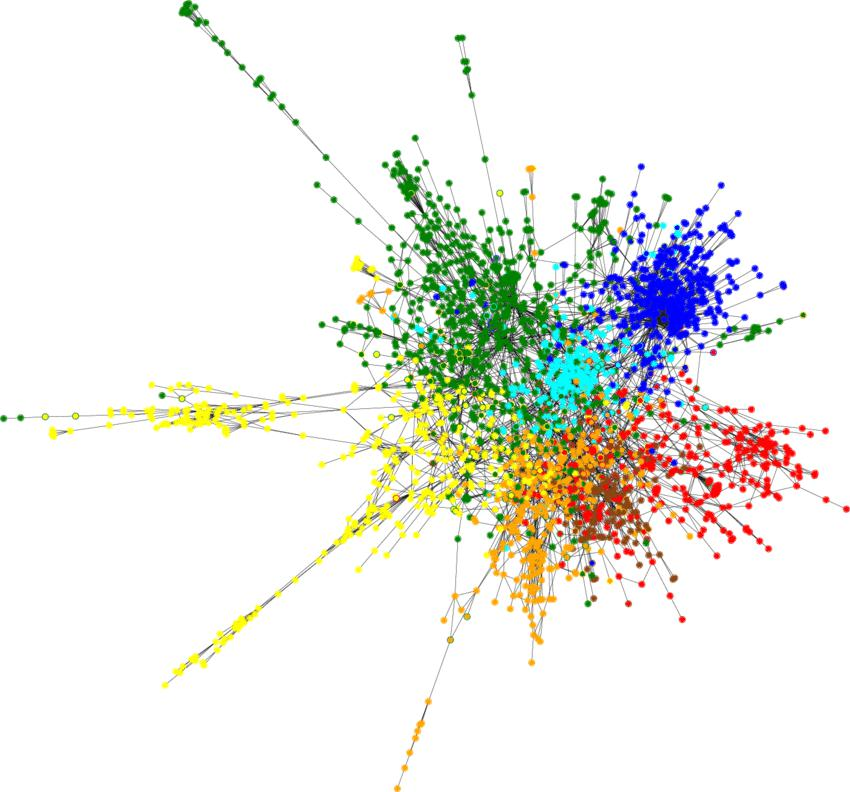

In [365]:
#@title # Módulos necesarios
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [366]:
!pip install -q torch-geometric # Install torch geometric

In [367]:
def visualize(h, color): # Función de visualización
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [368]:
#@title # otros módulos necesarios
from torch_geometric.datasets import Planetoid # llamamos el dataset necesario
from torch_geometric.transforms import NormalizeFeatures

In [369]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures()) # Definimos el dataset de trabajo

In [370]:
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


In [371]:
data=dataset[0]   # Definimos el dataset

In [372]:
print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')
print(f'Number of validation nodes: {data.val_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Number of test nodes: 1000
Number of validation nodes: 500
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Podemos ver que la red «Cora» contiene 2708 nodos y 10 556 aristas, lo que da como resultado un grado promedio de 3,9.
Para entrenar este conjunto de datos, se nos proporcionan las categorías de verdad fundamental de 140 nodos (20 para cada clase).
Esto da como resultado una tasa de etiquetado de nodos de entrenamiento de solo el 5 %.

Podemos ver además que esta red no está dirigida y que no existen nodos aislados (cada documento tiene al menos una cita).

## **Entrenando  una Graph Neural Network (GNN)**

## **Modelo 1**

In [373]:
import torch
from torch_geometric.nn import GCNConv # llamamos a GCNconv
import torch.nn.functional as F # Función de activación

class GCN_1(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567) # Seteamos una semilla
        self.conv1 = GCNConv(dataset.num_features, hidden_channels) # Capa 1
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes) # Capa 2

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu() # Función de activación
        x = F.dropout(x, p=0.5, training=self.training) # regularización
        x = self.conv2(x, edge_index)
        return x


In [374]:
model_1 = GCN_1(hidden_channels=16)
print(model_1)

GCN_1(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


Las capas GCNConv reducen la dimensionalidad de las características del nodo a 2, es decir, 1433 → 16 → 7

Visualicemos las node embeddings de nuestra red GCN **sin entrenar**.
Para la visualización, utilizamos [**TSNE**](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) para visualizar nuestras embeddings de nodos de 7 dimensiones en un plano 2D.

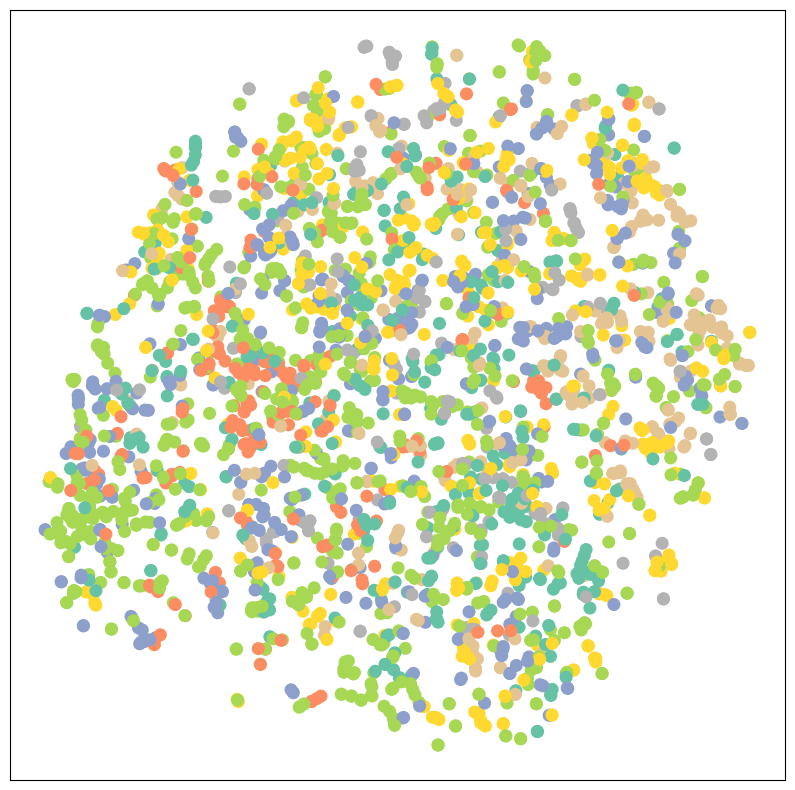

In [375]:
model_1.eval()

out = model_1(data.x, data.edge_index)
visualize(out, color=data.y)

Podemos mejorar si entrenamos nuestro modelo.
El procedimiento de entrenamiento se realizará con las características del nodo x y la conectividad gráfica edge_index como entrada para nuestro modelo GCN.

In [376]:
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [377]:
#@title # Definimos una función de entrenamiento
def train(model):
      model.train()  # Pone la red en modo de entrenamiento
      optimizer.zero_grad()  # Limpia los gradientes.
      out = model(data.x, data.edge_index)  # Realizar una predicción
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Calcula la perdida con los datos de entrenamiento
      loss.backward()  # Deriva los gradientes.
      optimizer.step()  # actualiza los parámetros en base a los gradientes
      return loss # Devuelve el valor de pérdida

In [378]:
#@title # Definimos una función para verificar la perdida del test de entrenamiento
def test_of_train(model):
      model.eval()  # Pone la red en modo de entrenamiento
      out = model(data.x, data.edge_index)  # Realizar una predicción
      return criterion(out[data.test_mask], data.y[data.test_mask]) # Devuelve el valor de pérdida

In [379]:
#@title # Definimos una función de testing
def test(model):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Usa la clase de mayor probabilidad
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Cálcula la perdida solo para los elementos del test
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Cálculo de test accuracy
      return test_acc

In [380]:
epochs=[]
losses=[]
test_losses=[]
for epoch in range(1, 601): # Entrenamiento por 100 epocas
    loss = train(model_1)
    epochs.append(epoch)
    losses.append(float(loss))
    loss_test = test_of_train(model_1)
    test_losses.append(float(loss_test))
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Test Loss: {loss_test:.4f}')

Epoch: 010, Train Loss: 1.8513, Test Loss: 1.8947
Epoch: 020, Train Loss: 1.6681, Test Loss: 1.7861
Epoch: 030, Train Loss: 1.4307, Test Loss: 1.6493
Epoch: 040, Train Loss: 1.1210, Test Loss: 1.4610
Epoch: 050, Train Loss: 0.8748, Test Loss: 1.2772
Epoch: 060, Train Loss: 0.6700, Test Loss: 1.1012
Epoch: 070, Train Loss: 0.4658, Test Loss: 0.9624
Epoch: 080, Train Loss: 0.3470, Test Loss: 0.8783
Epoch: 090, Train Loss: 0.3166, Test Loss: 0.8200
Epoch: 100, Train Loss: 0.2417, Test Loss: 0.7807
Epoch: 110, Train Loss: 0.2176, Test Loss: 0.7518
Epoch: 120, Train Loss: 0.1726, Test Loss: 0.7411
Epoch: 130, Train Loss: 0.1195, Test Loss: 0.7259
Epoch: 140, Train Loss: 0.1091, Test Loss: 0.7127
Epoch: 150, Train Loss: 0.1062, Test Loss: 0.7015
Epoch: 160, Train Loss: 0.0865, Test Loss: 0.7162
Epoch: 170, Train Loss: 0.0712, Test Loss: 0.6918
Epoch: 180, Train Loss: 0.0885, Test Loss: 0.6915
Epoch: 190, Train Loss: 0.0880, Test Loss: 0.7122
Epoch: 200, Train Loss: 0.0605, Test Loss: 0.7149


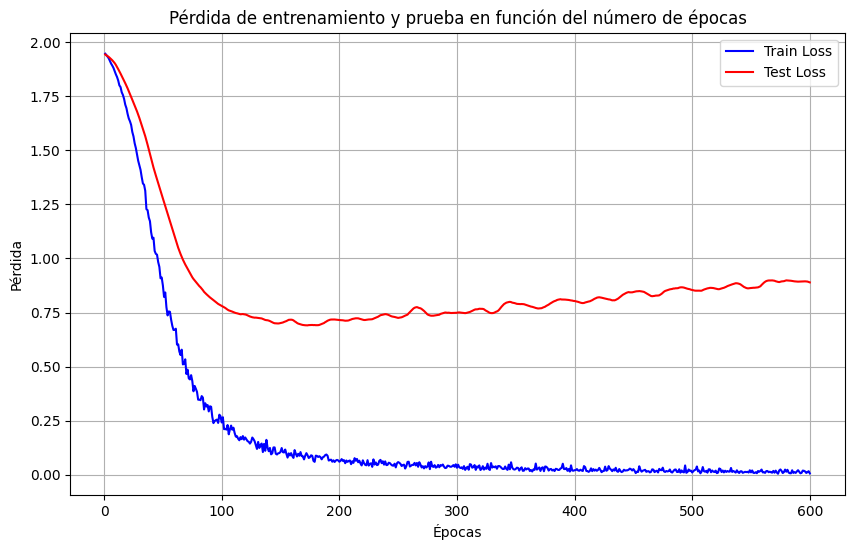

In [381]:
import matplotlib.pyplot as plt
import numpy as np

# Convertir las listas a arreglos NumPy
epochs_np = np.array(epochs)
losses_np = np.array(losses)
test_losses_np = np.array(test_losses)

# Graficar los datos
plt.figure(figsize=(10, 6))
plt.plot(epochs_np, losses_np, label='Train Loss', color='blue')
plt.plot(epochs_np, test_losses_np, label='Test Loss', color='red')
plt.title('Pérdida de entrenamiento y prueba en función del número de épocas')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.grid(True)
plt.legend()
plt.show()

Después de entrenar el modelo, podemos comprobar su precisión en la prueba:

In [382]:
test_acc = test(model_1)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7610


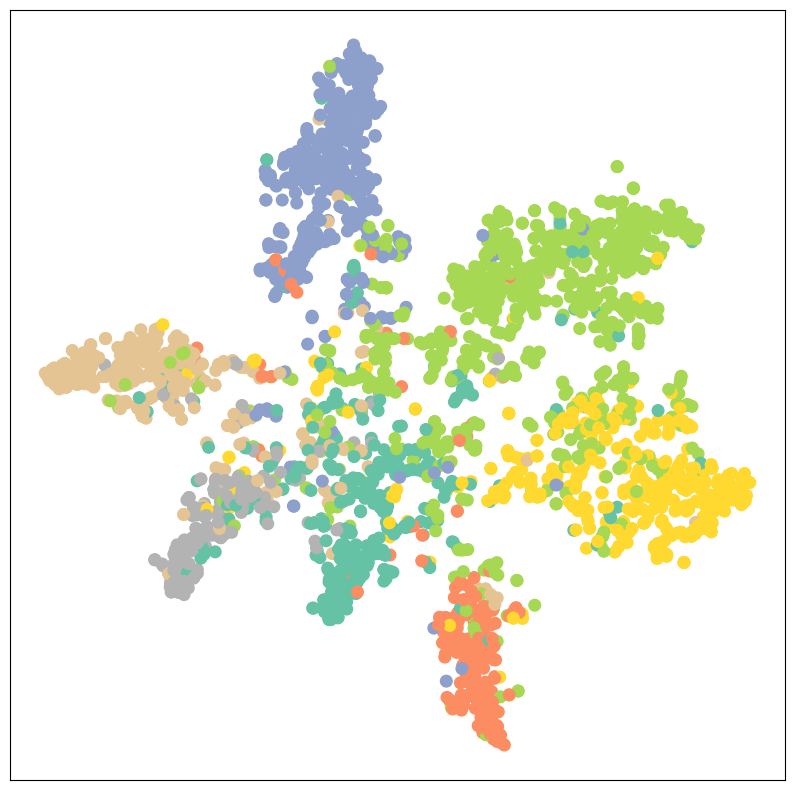

In [383]:
model_1.eval()

out = model_1(data.x, data.edge_index)
visualize(out, color=data.y)

## **Modelo 2**

In [384]:
import torch
from torch_geometric.nn import GCNConv # llamamos a GCNconv
import torch.nn.functional as F # Función de activación

class GCN_2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234567) # Seteamos una semilla
        self.conv1 = GCNConv(dataset.num_features, 32) # Capa 1
        self.conv2 = GCNConv(32, 16) # Capa 2
        self.conv3 = GCNConv(16, dataset.num_classes) # Capa 3

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu() # Función de activación
        x = self.conv2(x, edge_index)
        x = x.relu() # Función de activación
        x = F.dropout(x, p=0.5, training=self.training) # regularización
        x = self.conv3(x, edge_index)
        return x


In [385]:
model_2 = GCN_2()
print(model_2)

GCN_2(
  (conv1): GCNConv(1433, 32)
  (conv2): GCNConv(32, 16)
  (conv3): GCNConv(16, 7)
)


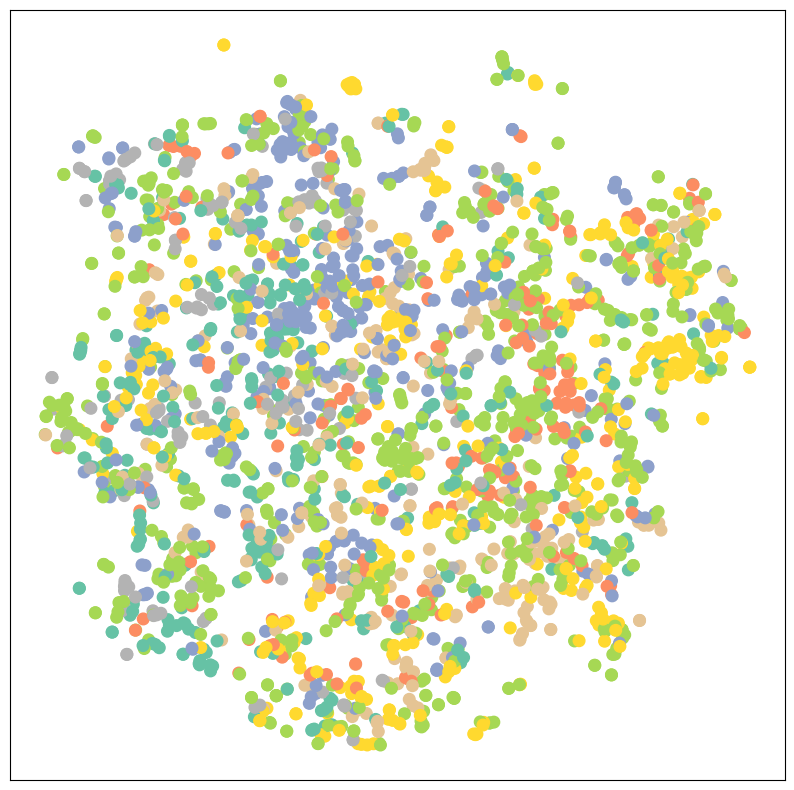

In [386]:
model_2.eval()

out = model_2(data.x, data.edge_index)
visualize(out, color=data.y)

## Probemos un entrenamiento

In [387]:
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.01)  # Se puede modificar el learning rate
criterion = torch.nn.CrossEntropyLoss()

In [388]:
#@title # Reutilizamos la función de train y test definidas antes
epochs=[]
losses=[]
test_losses=[]
for epoch in range(1, 601): # Entrenamiento por 100 epocas
    loss = train(model_2)
    epochs.append(epoch)
    losses.append(float(loss))
    loss_test = test_of_train(model_2)
    test_losses.append(float(loss_test))
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Test Loss: {loss_test:.4f}')

Epoch: 010, Train Loss: 1.8026, Test Loss: 1.8337
Epoch: 020, Train Loss: 1.3687, Test Loss: 1.5156
Epoch: 030, Train Loss: 0.8370, Test Loss: 1.1240
Epoch: 040, Train Loss: 0.4389, Test Loss: 0.7682
Epoch: 050, Train Loss: 0.1959, Test Loss: 0.6354
Epoch: 060, Train Loss: 0.1343, Test Loss: 0.6207
Epoch: 070, Train Loss: 0.0716, Test Loss: 0.6911
Epoch: 080, Train Loss: 0.0557, Test Loss: 0.7034
Epoch: 090, Train Loss: 0.0484, Test Loss: 0.7040
Epoch: 100, Train Loss: 0.0610, Test Loss: 0.7377
Epoch: 110, Train Loss: 0.0360, Test Loss: 0.7942
Epoch: 120, Train Loss: 0.0305, Test Loss: 0.8055
Epoch: 130, Train Loss: 0.0448, Test Loss: 0.8200
Epoch: 140, Train Loss: 0.0333, Test Loss: 0.8530
Epoch: 150, Train Loss: 0.0434, Test Loss: 0.8908
Epoch: 160, Train Loss: 0.0328, Test Loss: 0.9198
Epoch: 170, Train Loss: 0.0165, Test Loss: 0.8814
Epoch: 180, Train Loss: 0.0169, Test Loss: 1.0093
Epoch: 190, Train Loss: 0.0091, Test Loss: 0.9345
Epoch: 200, Train Loss: 0.0198, Test Loss: 1.0169


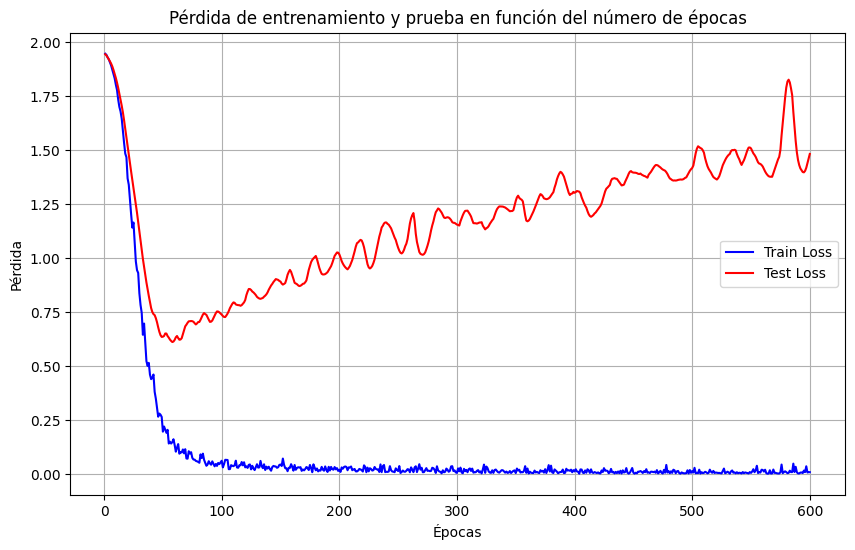

In [389]:
import matplotlib.pyplot as plt
import numpy as np

# Convertir las listas a arreglos NumPy
epochs_np = np.array(epochs)
losses_np = np.array(losses)
test_losses_np = np.array(test_losses)

# Graficar los datos
plt.figure(figsize=(10, 6))
plt.plot(epochs_np, losses_np, label='Train Loss', color='blue')
plt.plot(epochs_np, test_losses_np, label='Test Loss', color='red')
plt.title('Pérdida de entrenamiento y prueba en función del número de épocas')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.grid(True)
plt.legend()
plt.show()

In [390]:
test_acc = test(model_2)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7600


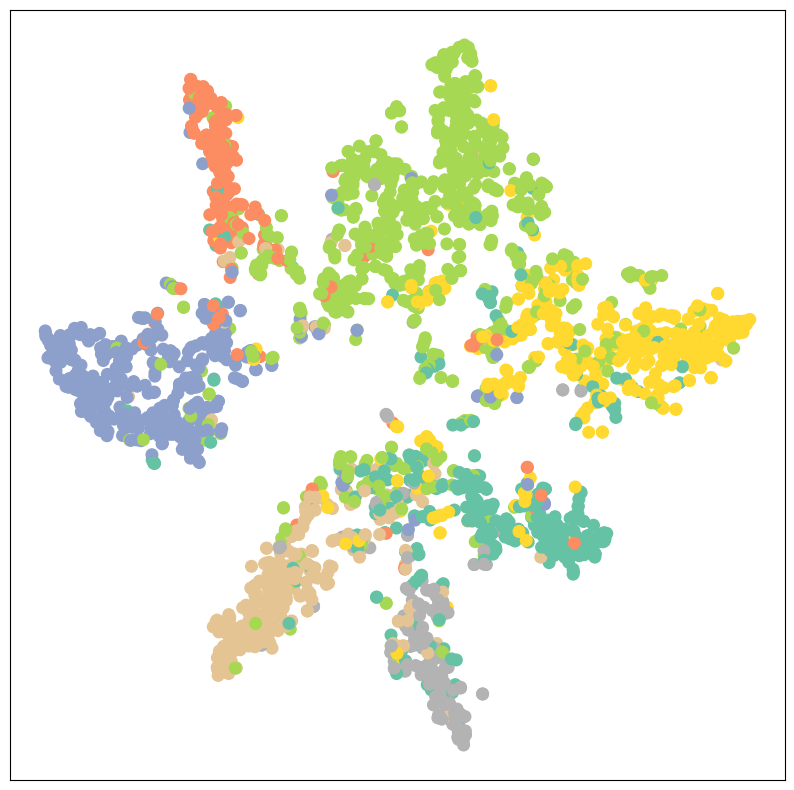

In [391]:
model_2.eval()

out = model_2(data.x, data.edge_index)
visualize(out, color=data.y)

## **Modelo 3**

In [392]:
import torch
from torch_geometric.nn import GCNConv # llamamos a GCNconv
import torch.nn.functional as F # Función de activación

class GCN_3(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234567) # Seteamos una semilla
        self.conv1 = GCNConv(dataset.num_features, 16) # Capa 1
        self.conv2 = GCNConv(16, dataset.num_classes) # Capa 3

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.tanh() # Función de activación
        x = self.conv2(x, edge_index)
        return x


In [393]:
model_3 = GCN_3()
print(model_3)

GCN_3(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


## Probemos un entrenamiento

In [394]:
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [395]:
#@title # Reutilizamos la función de train y test definidas antes
epochs=[]
losses=[]
test_losses=[]
for epoch in range(1, 601): # Entrenamiento por 100 epocas
    loss = train(model_3)
    epochs.append(epoch)
    losses.append(float(loss))
    loss_test = test_of_train(model_3)
    test_losses.append(float(loss_test))
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Test Loss: {loss_test:.4f}')

Epoch: 010, Train Loss: 1.7915, Test Loss: 1.8587
Epoch: 020, Train Loss: 1.5418, Test Loss: 1.7103
Epoch: 030, Train Loss: 1.2238, Test Loss: 1.5241
Epoch: 040, Train Loss: 0.8915, Test Loss: 1.3177
Epoch: 050, Train Loss: 0.6081, Test Loss: 1.1277
Epoch: 060, Train Loss: 0.4032, Test Loss: 0.9796
Epoch: 070, Train Loss: 0.2693, Test Loss: 0.8778
Epoch: 080, Train Loss: 0.1850, Test Loss: 0.8127
Epoch: 090, Train Loss: 0.1318, Test Loss: 0.7725
Epoch: 100, Train Loss: 0.0978, Test Loss: 0.7476
Epoch: 110, Train Loss: 0.0754, Test Loss: 0.7320
Epoch: 120, Train Loss: 0.0599, Test Loss: 0.7219
Epoch: 130, Train Loss: 0.0489, Test Loss: 0.7153
Epoch: 140, Train Loss: 0.0408, Test Loss: 0.7112
Epoch: 150, Train Loss: 0.0346, Test Loss: 0.7089
Epoch: 160, Train Loss: 0.0298, Test Loss: 0.7078
Epoch: 170, Train Loss: 0.0260, Test Loss: 0.7076
Epoch: 180, Train Loss: 0.0228, Test Loss: 0.7081
Epoch: 190, Train Loss: 0.0203, Test Loss: 0.7091
Epoch: 200, Train Loss: 0.0181, Test Loss: 0.7104


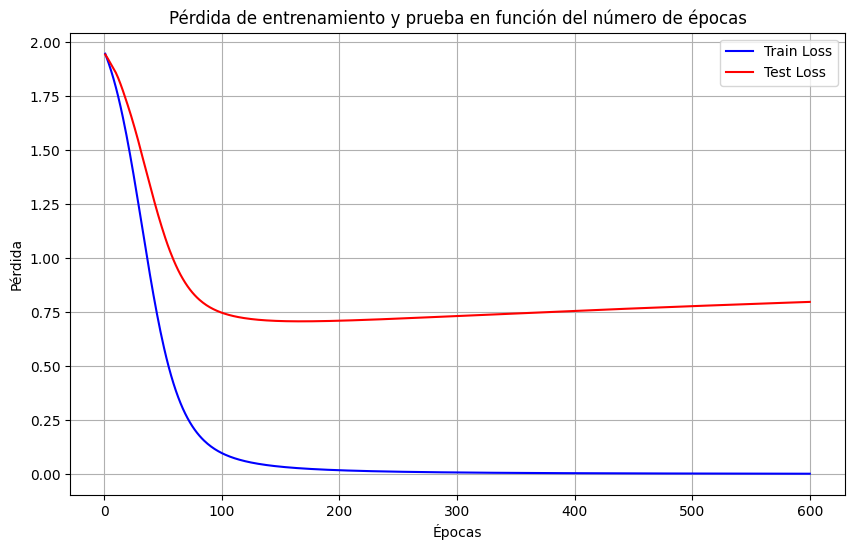

In [396]:
import matplotlib.pyplot as plt
import numpy as np

# Convertir las listas a arreglos NumPy
epochs_np = np.array(epochs)
losses_np = np.array(losses)
test_losses_np = np.array(test_losses)

# Graficar los datos
plt.figure(figsize=(10, 6))
plt.plot(epochs_np, losses_np, label='Train Loss', color='blue')
plt.plot(epochs_np, test_losses_np, label='Test Loss', color='red')
plt.title('Pérdida de entrenamiento y prueba en función del número de épocas')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.grid(True)
plt.legend()
plt.show()

In [397]:
test_acc = test(model_3)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7780


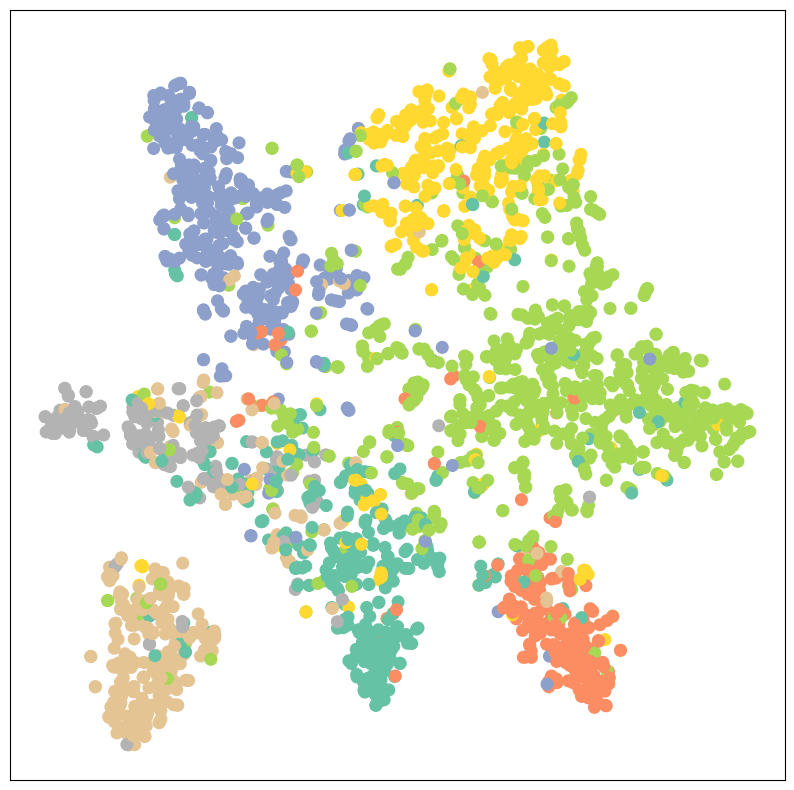

In [398]:
model_3.eval()

out = model_3(data.x, data.edge_index)
visualize(out, color=data.y)

## **Actividades**



##*   Modificar el número de capas buscando mejorar los resultados del test.
##*   Modificar el learning rate de optimizador ADAM.
##*   Utilizar otro optimizador como SDG y comparar los resultados.
##*   Investigar sobre otras funciones de activación que podrian utilizrse e implementarlas.
##*   Modificar el número de epocas en los modelos creados para ver si los resultados cambian.

